# Projekt MAGN — Implementacja biblioteki do budowy Multi-Associative Graph Network (MAGN) oraz uczenia (klasyfikacja)
### Autorzy:

- Szymon Jurecki
- Dominik Breksa

### Opis projektu:

Z uwagi na to, że ilość wyprodukowanego przez nas kodu jest zbyt duża, aby umieścić go w jednym pliku, postanowiliśmy stworzyć bibliotekę `magn` w języku python, która realizuje odpowiednie implementacje np. uczenia, tworzenia grafów ASA.

Ponieważ jest to dość rozległy projekt, to pozwolę sobie opisać strukturę projektu:
- Folder `docs` - zawiera wewnętrzną dokumentację, obrazki i zapisy literatury.
- Folder `resources/data` - tutaj znajduje się baza danych później pobrana z platformy Kaggle.
- Folder `src` - ma kod źródłowy paczek python, które stworzyliśmy:
    - Folder `magn` - zawiera paczkę użytą dalej do stworzenia MAGN.
- Folder `tests` - zawiera tymczasowe testy, zbudowanych przez nas method, funkcji i obiektów.
- Plik `.gitignore` - samo opisowe.
- Plik `pyproject.toml` - informacje o paczce niezbędne do instalacji.
- Plik `README.md` - ten tekst.
- PLik `requiements.txt` - zawiera niezbędne paczki zależności.
- Plik `setup.py` - instaluje naszą paczkę.

Następnie pobierzemy bazę danych z platformy Kaggle ([LINK](https://www.kaggle.com)) w formacie SQLite, na jej podstawie zbudujemy konkretny MAGN, potem przeprowadzimy uczenie i przeanalizujemy wyniki w tym notebooku.

### Cel projektu:

1. Implementacja następujących struktur danych dla małej biblioteki:
    - Aggregative Sorting Associative Graphs (ASA-Graphs)
    - Multi-Associative Graph Network (MAGN)
    - Baza danych
2. Przeprowadzenie uczenia na przykładowej bazie danych:
    - Uczenie
    - Predykcja
    - Obliczenie metryk i porównanie działania.

### Wstęp teoretyczny

Relacyjne bazy danych, pomimo tego, jak często są używane, nie są zbyt dobre w reprezentacji relacji ściśle związanych z podobieństwem między np.: wartościami, kolejnością poszczególnych danych wewnątrz tabel.

W związku z tym wprowadzimy tak zwane Multi-Associative Graph Network (MAGN), zbudowane na podstawie konkretnych baz danych i pokażemy, że można je wykorzystać np. predykcji.

##### Co to są Aggregative Sorting Associative Graphs (ASA-Graphs)?

W skrócie są to B-Drzewa, gdzie wszystkie wierzchołki są ze sobą połączone w posortowanej kolejności przy pomocy listy dwukierunkowej. Te B-Drzewa mają kilka ograniczeń np. to, że w danym wierzchołku nie mogą być więcej niż 2 elementy.

![ASA template](docs/examples/data/templatepng.png)

Gdzie:
- `Table` - Nasza konwencja podpisywania, z jakiej tabeli jest graf.
- `Column` - Nasza konwencja podpisywania, z jakiej kolumny jest graf.
- `Counter` - Licznik ile razy w danej porcji danych nastąpiło powtórzeń danego obiektu.
- `Key` - Sama wartość elementu.
- `Left Pointer` - Wartość pointera dla lewego krańca listy dwukierunkowej.
- `Right Pointer` - Wartość pointera dla prawego krańca listy dwukierunkowej.
- `pk:Numer` - Numer klucza, jakiego obiekt się tyczy (dla ułatwienia).
- Warto wspomnieć, że na tym zdjęciu jeszcze nie ma wag.

Przykładowy ASA może wyglądać na przykład tak.

![ASA przykładowy](docs/examples/data/animals_species_4.png)

##### Jak stworzyć MAGN?

Należy wykorzystać tak zwany algorytm transformacji asocjatywnej na konkretnej bazie danych. Poniżej przedstawimy pseudokod.

```python
def create_magn():
    db = obtain_database()  # (1)
    
    magn = create_empty_magn()  # (2)
    
    for table in db.get_tables_pk_first():  # (3)
        for column in table:  # (4)
            data = column.data
            asa = create_asa(data)  # (5)
            magn.add_asa(asa, asa.connected_objects)  # (6)
    
    return magn
```

1. Dostań gotową bazę danych wypełnioną kluczami i danymi.
2. Stwórz pusty MAGN, aby móc potem dodać do niego poszczególne ASA.
3. Należy w odpowiedni sposób dostarczać do niego grafy asa, tak, any najpierw dać klucze główne, a potem odsłonione przez nie klucze obce, więc należy dodać je w odpowiedni sposób (konkretnie my wykorzystaliśmy sortowanie topologi-cze z zależności między kluczami).
4. Prze-iteruj przez wszystkie kolumny.
5. Stwórz z nich odpowiedni graf asa.
6. Dodaj go łącznie z przyległymi obiektami do głównego MAGN.

Należy pamiętać, że pomiędzy obiektami i elementami grafu ASA należy wyliczać odpowiednie wagi i połączyć wszystko w całość.

Obliczanie wag:
1. ....
2. ....
3. ....
4. ....

##### Przykładowy MAGN:

Dane i schematy użyte do konstrukcji (pominięto z uwagi na skalę tego niektóre klucze).

![Magn data](docs/examples/data/data.png)

![Magn schema](docs/examples/data/data_schema.png)

Gotowy MAGN stworzony ręcznie.

![Przykładowy MAGN](docs/examples/data/magn.png)

Infografiki własne.

##### Algorytm uczenia

Poniżej zamieszczę pseudo kod uczenia się MAGN:

```python
def fit_magn(magn, data, targets, learning_rate, epochs):
    for _ in range(epochs):  # (1)
        for row in data:  # (2)
            activated_neurons = magn.all_neurons - targets[row].neurons  # (3)
            delta = calculate_normalized_delta(activated_neurons, targets[row].neurons)  # (4)
            
            paths = bfs(start=targets[row].neurons, by=activated_neurons)  # (5)
            for neuron in paths.unique():  # (6)
                if delta == 0.0:  # (7)
                    neuron.p *= (1.0 + learning_rate * neuron.activation)
                else:
                    neuron.p *= (1.0 - learning_rate * neuron.activation * delta)
```

1. Iteruj po podanej liczbie epok.
2. Iteruj po wszystkich danych treningowych.
3. Znajdź wszystkie aktywowane neurony i nie dołączaj danych docelowych.
4. Oblicz i normalizuj dane, aby znaleźć deltę.
5. Znajdź wszystkie ścieżki prowadzące od neuronów docelowych, przechodzące przez aktywowane neurony.
6. Iteruj po unikalnych ścieżkach neuronowych.
7. Na podstawie deltę wynoszącą 0 oblicz wartość p neuronu.

##### Algorytm predykcji

Poniżej zamieszczę pseudo kod predykcji MAGN:

```python
def predict_magn(magn, data, target_label):
    paths = bfs(by=magns.neurons, searching=target_label)  # (1)
    
    stimulation = magn.calculate_sitmulation(path for path in paths)  # (2)
    max_stimulation_index = stimulation.argmax()
    
    maximum_path = paths[max_stimulation_index]
    
    maximum_element = maximum_pathx.last()  # (3)
    return maximum_element.key  # (4)
```

1. Znajdź wszystkie ścieżki ze wszystkich neuronów przechodzące przez magn neurons i wyszukując target_label (nazwa kolumny, którą chcemy przewidzieć).
2. Oblicz pobudzenie dla każdej ścieżki.
3. Wybierz ścieżkę z maksymalną stymulacją i znajdź ostatni element ścieżki.
4. Zdobądź klucz tego elementu.

### Wykorzystane technologie i zależności:
- Python: `3.12.0`
- Pandas: `2.2.2`
- Kaggle: `1.6.14`
- SQLite3: `3.46.0`
- Inne zawarte w `requirements.txt`

### Niezbędne instalacje

Aby móc użyć tego notebooka zalecane jest stworzenie odrębnego wirtualnego środowiska Python -a (venv) i zainstalowania niezbędnych zależności. Sama biblioteka zainstaluje się po wykonaniu linijki: `pip install .`, ale dodatkowo, aby ją przedstawić w tym, notebooku musimy jeszcze doinstalować kilka kolejnych modułów.

In [1]:
%pip install .
%pip install scikit-learn
%pip install numpy
%pip install kaggle
%pip install matplotlib

Processing c:\users\domin\pycharmprojects\ggsn---magn
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for magn: filename=magn-1.0.0.0-py3-none-any.whl size=18239 sha256=1e1b5d6efdcd608f1df899777317a962958864540ad3fd71959e708e6a4e3cc4
  Stored in directory: c:\users\domin\appdata\local\pip\cache\wheels\02\69\7a\7a321fc99cdf850f17c5dbe96e53ef1e4b07adda9d5bd3d1f7
Successfully built magn
  Attempting uninstall: magn
    Found existing installation: magn 1.0.0.0
    Not uninstalling magn at c:\users\domin\pycharmprojects\ggsn---magn\src, outside environment C:\Users\domin\PycharmProjects\GGSN--

DEPRECATION: Loading egg at c:\users\domin\pycharmprojects\ggsn---magn\.venv\lib\site-packages\magn-1.0.0.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\domin\pycharmprojects\ggsn---magn\.venv\lib\site-packages\magn-1.0.0.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\domin\pycharmprojects\ggsn---magn\.venv\lib\site-packages\magn-1.0.0.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\domin\pycharmprojects\ggsn---magn\.venv\lib\site-packages\magn-1.0.0.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


DEPRECATION: Loading egg at c:\users\domin\pycharmprojects\ggsn---magn\.venv\lib\site-packages\magn-1.0.0.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


Importy i konfiguracje bibliotek.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'

### Pobranie oraz Przygotowanie Danych

Aby przetestować, zbudowaną przez nas bibliotekę pobierzemy zbiór danych z platformy Kaggle.

Zbiór danych w formie bazy danych sqlite:
- Zbiór ocen piosenek muzycznych z platformy Pitchfork (Formalnie dalej nazywany `Pitchfork`) — [Link do danych z platformy Kaggle](https://www.kaggle.com/datasets/nolanbconaway/pitchfork-data)

In [4]:
from pathlib import Path
from typing import Final

resources_dir: Final[Path] = Path('resources/data/')

zip_data_file_pitchfork: Final[Path] = resources_dir.joinpath('pitchfork-data.zip')
database_path_pitchfork: Final[Path]  = resources_dir.joinpath('database.sqlite')

Pobranie zbioru danych i umieszczenie go w folderze `./resources/data/` do dalszej eksploatacji.

In [5]:
from os.path import exists
    
if not exists(zip_data_file_pitchfork):
    !kaggle datasets download -d nolanbconaway/pitchfork-data -p resources/data

Rozpakowanie danych do odpowiedniego katalogu: `./resources/data/`, aby móc użyć faktycznie bazę.

In [6]:
from zipfile import ZipFile

if not exists(database_path_pitchfork):
    with ZipFile(zip_data_file_pitchfork, 'r') as zip_ref:
        zip_ref.extractall(resources_dir)

Funkcje pomocnicze potrzebne do przekształcenia naszej pobranej bazy danych, ponieważ z niewiadomego mi powodu wszystkie bazy danych SQLite, pobrane z platformy kaggle nie zawierają np. kluczy głównych, obcych.

In [7]:
from typing import List, Tuple
import sqlite3

def get_table_columns_types(db_cursor: sqlite3.Cursor, table_name: str) -> List[Tuple[str, str]]:
    """Returns a list of tuples containing the column name and data type of given table in a database."""

    info = db_cursor.execute(f"""
        PRAGMA
            table_info({table_name});
    """).fetchall()

    return list((table_info[1], table_info[2]) for table_info in info)

def get_table_names(db_cursor: sqlite3.Cursor) -> List[str]:
    """Gets the names of all sqlite tables from a database."""
    db_cursor.execute("""
        SELECT
            name
        FROM
            sqlite_master
        WHERE
            type='table'
    """)

    return list(table[0] for table in db_cursor.fetchall())

def move_data_and_switch_tables(db_cursor: sqlite3.Cursor, table_name: str, temporary_table_name: str) -> None:
    """Moves data from a temporary table to the original table and switches the tables in a database."""

    db_cursor.executescript(f"""
        -- Move the data
        INSERT INTO
            {temporary_table_name}
        SELECT
            *
        FROM
            {table_name};
        
        -- Drop the old table
        DROP TABLE
            {table_name};
        
        -- Rename the new table
        ALTER TABLE
            {temporary_table_name}
        RENAME TO
            {table_name};
    """)

def create_table_with_primary_key(db_cursor: sqlite3.Cursor, table_name: str, temporary_table_name: str, column_name: str) -> None:
    """Creates a table with a primary key in a database."""

    table_columns = get_table_columns_types(db_cursor, table_name)

    db_cursor.execute(f"""
        CREATE TABLE {temporary_table_name} (
            {
                ', '.join(
                    f'{column} {data_type}'
                    if column != column_name
                    else f'{column} {data_type} PRIMARY KEY'
                    for column, data_type in table_columns
                )
            }
        );
    """)

def create_table_with_foreign_key(db_cursor: sqlite3.Cursor, table_name: str, column_name: str, foreign_table_name: str, foreign_column_name: str, temporary_foreign_table_name: str) -> None:
    """Creates a table with a foreign key in a database."""

    foreign_table_columns = get_table_columns_types(db_cursor, foreign_table_name)

    db_cursor.execute(f"""
        CREATE TABLE {temporary_foreign_table_name} (
            {
                ', '.join(
                    f'{column} {data_type}'
                    for column, data_type in foreign_table_columns
                )
            },
            CONSTRAINT fk_{foreign_table_name}_{foreign_column_name}
                FOREIGN KEY
                    ({foreign_column_name})
                REFERENCES
                    {table_name} ({column_name})
        );
    """)

Z uwagi, że całość musieliśmy zaimplementować w Python -ie to postanowiliśmy ograniczyć dane uczące do około 1000 rekordów z wszystkich tabel. Dla szybkości uczenia i dla ograniczenia złożoności pamięciowej użytkowników o trochę mniejszych komputerach.

Zapraszamy do bawienia się tymi parametrami do sprawdzenia wyników uczenia, predykcji przy zmniejszeniu lub zwiększeniu tej liczby. Cały zbiór danych ma około 18000 rekordów.

Wyczyścimy sobie też nasze dane, tak aby np. braki w jakiejś kolumnie, nie zepsuły nam wyników uczenia. Usuniemy też błędne i niepotrzebne duplikaty w kluczach głównych. Na spokojnie duplikaty wartości innych niż klucze zostawiamy w spokoju, ponieważ są one potrzebne dla ASA grafów w MAGN.

In [8]:
def limit_rows(db_cursor: sqlite3.Cursor, column_name: str, max_rows: int) -> None:
    """Limits the number of rows in a table in a database."""
    
    all_tables = get_table_names(db_cursor)
    
    # From every table and every column deletes rows that are NULL
    for table_name in all_tables:
        for given_column_name, _ in get_table_columns_types(db_cursor, table_name):
            db_cursor.execute(f"""
                DELETE FROM
                    {table_name}
                WHERE
                    {given_column_name} IS NULL;
            """)
    
    # From every table delete rows that are a duplicate of the column_name
    for table_name in all_tables:
        db_cursor.execute(f"""
            DELETE FROM
                {table_name}
            WHERE
                {column_name} IN (
                    SELECT
                        {column_name}
                    FROM
                        {table_name}
                    GROUP BY
                        {column_name}
                    HAVING
                        COUNT(*) > 1
                );
        """)
    
    # Find the intersection of a column_name in every table
    # Delete rows that are not in the intersection
    intersection: str = 'INTERSECT'.join(f"""
        SELECT
            {column_name}
        FROM
            {intersection_table_name}
    """ for intersection_table_name in all_tables)
    
    for table_name in all_tables:
        db_cursor.execute(f"""
            DELETE FROM
                {table_name}
            WHERE
                {column_name} NOT IN (
                    {intersection}
                );
        """)
    
    # Limit the number of rows in a table to max_rows
    for table_name in all_tables:
        db_cursor.execute(f"""
            DELETE FROM
                {table_name}
            WHERE
                {column_name} NOT IN (
                    SELECT
                        {column_name}
                    FROM
                        {table_name}
                    ORDER BY
                        {column_name}
                    LIMIT {max_rows}
                );
        """)

In [9]:
from typing import Final

MAX_ROWS: Final[int] = 200

In [10]:
with sqlite3.connect(database_path_pitchfork) as conn:
    limit_rows(conn.cursor(), 'reviewid', MAX_ROWS)

Dodanie kluczy głównych i obcych do bazy danych, ponieważ nie zostały one dodane podczas tworzenia na platformie Kaggle, a jest to ważne podczas tworzenia MAGN.

W tym modelu przyjęliśmy, że klucze zawsze są jedno kolumnowe.

In [11]:
def add_foreign_key(db_cursor: sqlite3.Cursor, table_name: str, column_name: str, foreign_table_name: str, foreign_column_name: str) -> None:
    """Adds a foreign key to a given table column in a database."""

    temporary_foreign_table_name = f'{foreign_table_name}_'

    db_cursor.execute(f"""
        PRAGMA
            foreign_keys = OFF;
    """)

    create_table_with_foreign_key(db_cursor, table_name, column_name, foreign_table_name, foreign_column_name, temporary_foreign_table_name)
    move_data_and_switch_tables(db_cursor, foreign_table_name, temporary_foreign_table_name)

    db_cursor.execute(f"""
        PRAGMA
            foreign_keys = ON;
    """)

def add_primary_key(db_cursor: sqlite3.Cursor, table_name: str, column_name: str) -> None:
    """Adds a primary key to a given table column in a database."""

    temporary_table_name = f'{table_name}_'

    create_table_with_primary_key(db_cursor, table_name, temporary_table_name, column_name)
    move_data_and_switch_tables(db_cursor, table_name, temporary_table_name)

In [12]:
with sqlite3.connect(database_path_pitchfork) as conn:
    cursor = conn.cursor()

    cursor.execute(f"""BEGIN;""")
    try:
        add_primary_key(cursor, 'reviews', 'reviewid')

        add_foreign_key(cursor, 'reviews', 'reviewid', 'artists', 'reviewid')
        add_foreign_key(cursor, 'reviews', 'reviewid', 'content', 'reviewid')
        add_foreign_key(cursor, 'reviews', 'reviewid', 'genres', 'reviewid')
        add_foreign_key(cursor, 'reviews', 'reviewid', 'labels', 'reviewid')
        add_foreign_key(cursor, 'reviews', 'reviewid', 'years', 'reviewid')
    except Exception as error:
        conn.rollback()
        raise error
    else:
        conn.commit()

### Pełny ERD dla bazy danych Pitchfork

Poniżej przedstawiam schemat bazy danych `Pitchfork`.

![ERD Diagram for the database schema](docs/images/database_erd_pitchfork.png)

Został wygenerowany przez nas przy pomocy PyCharm oraz znajduje się w folderze `docs/images/database_erd_pitchfork.png`

Zobaczmy, jak nasze funkcje od konwersji do MAGN widzą powyższa baza danych.

Warto zauważyć, że meta-tabela (`sqlite_master`) nie jest brana pod uwagę, ponieważ z technicznego punktu widzenia to nie tabela, tylko interface do metadanych bazy.

In [13]:
from magn.database.sqlite3 import get_table_names

all_tables_pitchfork = get_table_names(database_path_pitchfork)

all_tables_pitchfork

['reviews', 'artists', 'content', 'genres', 'labels', 'years']

Teraz zobaczmy, czy nasze funkcje wyłuskały wszystkie zdefiniowane wcześniej relacje. Dla przypomnienia dla poszczególnych tabel to powinno tak wyglądać:
1. `Pitchfork`:
   - Klucz główny w `reviews`, `reviewid`
   - Klucz obcy w `artists`, `reviewid`
   - Klucz obcy w `content`, `reviewid`
   - Klucz obcy w `genres`, `reviewid`
   - Klucz obcy w `labels`, `reviewid`
   - Klucz obcy w `years`, `reviewid`

Poniżej zamieszczam jak należy rozumieć to wyjście zmiennej (`keys_%`):

![ERD Diagram with key output explanation](docs/images/database_erd_pitchfork_foreign_keys.png)

Oznaczenia:
- `Czerwony` - Obecna tabela, której klucze obce się tyczą.
- `Niebieski` - Tabela końcowa zawierająca klucz główny, który referenconujemy.
- `Żółty` - Kolumna z kluczem obcym.
- `Zielony` - Kolumna z kluczem głównym.

In [14]:
from magn.database.sqlite3 import SQLite3KeysReader

keys_reader = SQLite3KeysReader(database_path_pitchfork, all_tables_pitchfork)
keys_pitchfork = keys_reader.read()

keys_pitchfork

{'reviews': Keys(primary_keys=['reviewid'], foreign_keys={}),
 'artists': Keys(primary_keys=[], foreign_keys={'reviews': ('reviewid', 'reviewid')}),
 'content': Keys(primary_keys=[], foreign_keys={'reviews': ('reviewid', 'reviewid')}),
 'genres': Keys(primary_keys=[], foreign_keys={'reviews': ('reviewid', 'reviewid')}),
 'labels': Keys(primary_keys=[], foreign_keys={'reviews': ('reviewid', 'reviewid')}),
 'years': Keys(primary_keys=[], foreign_keys={'reviews': ('reviewid', 'reviewid')})}

Tutaj zwrócimy jakie dane z tabel w postaci pandas Dataframe -u zostały znalezione (przynajmniej skrótowo)

In [15]:
from magn.database.sqlite3 import SQLite3DataReader

data_reader = SQLite3DataReader(database_path_pitchfork, all_tables_pitchfork, keys_pitchfork)
data_reader.read()

{'reviews':                                      title                artist  \
 reviewid                                                           
 1                            young forever             aberfeldy   
 6                     pure tone audiometry              aarktica   
 11           homesick and happy to be here              aberdeen   
 31                             rolled gold                action   
 33                the scene's out of sight          actionslacks   
 ...                                    ...                   ...   
 1069            this right here is buck 65               buck 65   
 1072                                gnayse                  bola   
 1073      music to climb the apple tree by        beat happening   
 1076                      the omaha record  bottom of the hudson   
 1078                        big star story              big star   
 
                                                         url  score  \
 reviewid          

Tak by wyglądało odczytanie przez nas gotowej bazy danych w całości.

In [16]:
from magn.database.database import Database

database_pitchfork = Database.from_sqlite3(database_path_pitchfork)

database_pitchfork

Database(all_data={'reviews': Table(data=                                     title                artist  \
reviewid                                                           
1                            young forever             aberfeldy   
6                     pure tone audiometry              aarktica   
11           homesick and happy to be here              aberdeen   
31                             rolled gold                action   
33                the scene's out of sight          actionslacks   
...                                    ...                   ...   
1069            this right here is buck 65               buck 65   
1072                                gnayse                  bola   
1073      music to climb the apple tree by        beat happening   
1076                      the omaha record  bottom of the hudson   
1078                        big star story              big star   

                                                        url  score  \
revi

In [17]:
from magn.magn import MAGNGraph

magn = MAGNGraph.from_sqlite3(database_path_pitchfork)

Processing tables...
Table reviews processed.
Table years processed.
Table labels processed.
Table genres processed.
Table content processed.
Table artists processed.
Tables processed.


Teraz przygotujemy odpowiednio dane uczące, walidacyjne i testowe.

Całość (1000 rekordów) podzielimy na następujące zbiory:
- Zbiór treningowy (700 rekordów)
- Zbiór walidacyjny (200 rekordów)
- Zbiór testowy (100 rekordów)

In [18]:
from random import randint

TRAIN_SIZE: Final[int] = 100
VALIDATION_SIZE: Final[int] = 50
TEST_SIZE: Final[int] = 50

assert TRAIN_SIZE + VALIDATION_SIZE + TEST_SIZE == MAX_ROWS, "We do not use all of the amount of data that was given earlier."

Wybieramy sobie daną tabelę i do niej doklejamy kolumnę "target" zawierającą, która zawiera losowe nazwy kolumn, które będziemy wybierać jako targety do uczenia, tak aby później można było wybrać dowolne kolumny jako listy cech oraz jako kolumny predykowane.

In [19]:
labeled_data = database_pitchfork.create_mock_target('reviews', seed_id=randint(0, 1000))

Podziel dane na odpowiednie zbiory.

In [20]:
train_data = labeled_data[:TEST_SIZE]
validation_data = labeled_data[TEST_SIZE: TEST_SIZE + VALIDATION_SIZE]
test_data = labeled_data[TEST_SIZE + VALIDATION_SIZE: TEST_SIZE + VALIDATION_SIZE + TEST_SIZE]

Zwizualizuj zbiory danych

In [21]:
train_data

,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,target
reviewid,,,,,,,,,,,,,
1,young forever,aberfeldy,http://pitchfork.com/reviews/albums/1-young-fo...,3.4,0,marc hogan,senior staff writer,2004-08-30,0,30,8,2004,url
6,pure tone audiometry,aarktica,http://pitchfork.com/reviews/albums/6-pure-ton...,7.4,0,eric carr,contributor,2003-04-08,1,8,4,2003,pub_month
11,homesick and happy to be here,aberdeen,http://pitchfork.com/reviews/albums/11-homesic...,7.0,0,joe tangari,contributor,2002-11-04,0,4,11,2002,best_new_music
31,rolled gold,action,http://pitchfork.com/reviews/albums/31-rolled-...,8.0,0,dominique leone,contributor,2002-11-20,2,20,11,2002,title
33,the scene's out of sight,actionslacks,http://pitchfork.com/reviews/albums/33-the-sce...,7.6,0,ryan schreiber,editor-in-chief,2000-12-31,6,31,12,2000,pub_month
40,rock n roll,ryan adams,http://pitchfork.com/reviews/albums/40-rock-n-...,2.9,0,amanda petrusich,contributor,2003-11-09,6,9,11,2003,author
44,29,ryan adams,http://pitchfork.com/reviews/albums/44-29/,6.8,0,amanda petrusich,contributor,2005-12-15,3,15,12,2005,artist
55,resuscitation,adult.,http://pitchfork.com/reviews/albums/55-resusci...,8.7,0,nitsuh abebe,contributor,2002-12-12,3,12,12,2002,best_new_music
56,anxiety always,adult.,http://pitchfork.com/reviews/albums/56-anxiety...,7.9,0,nitsuh abebe,contributor,2003-04-06,6,6,4,2003,pub_month


In [22]:
validation_data

,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,target
reviewid,,,,,,,,,,,,,
227,26 mixes for cash,aphex twin,http://pitchfork.com/reviews/albums/227-26-mix...,7.7,0,andy beta,contributor,2003-04-10,3,10,4,2003,best_new_music
239,hangable auto bulb,afx,http://pitchfork.com/reviews/albums/239-hangab...,8.9,0,mark richardson,executive editor,2005-11-02,2,2,11,2005,pub_month
240,chosen lords,afx,http://pitchfork.com/reviews/albums/240-chosen...,7.9,0,mark pytlik,contributor,2006-04-18,1,18,4,2006,best_new_music
259,two conversations,the appleseed cast,http://pitchfork.com/reviews/albums/259-two-co...,4.2,0,rob mitchum,contributor,2003-09-01,0,1,9,2003,pub_weekday
262,peregrine,the appleseed cast,http://pitchfork.com/reviews/albums/262-peregr...,7.3,0,brian howe,contributor,2006-04-06,3,6,4,2006,url
265,imperial metric,appliance,http://pitchfork.com/reviews/albums/265-imperi...,7.8,0,paul cooper,contributor,2001-10-04,3,4,10,2001,score
274,elephant shoe,arab strap,http://pitchfork.com/reviews/albums/274-elepha...,8.4,0,paul cooper,contributor,2000-06-06,1,6,6,2000,artist
275,the last romance,arab strap,http://pitchfork.com/reviews/albums/275-the-la...,8.0,0,matthew murphy,contributor,2005-10-18,1,18,10,2005,pub_weekday
283,free in the streets,a.r.e. weapons,http://pitchfork.com/reviews/albums/283-free-i...,6.0,0,brian howe,contributor,2006-02-13,0,13,2,2006,pub_weekday


In [23]:
test_data

,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,target
reviewid,,,,,,,,,,,,,
481,acoustica,alarm will sound,http://pitchfork.com/reviews/albums/481-acoust...,5.9,0,mark richardson,executive editor,2005-08-18,3,18,8,2005,pub_date
485,dimanche bamako,amadou & mariam,http://pitchfork.com/reviews/albums/485-dimanc...,8.0,0,joe tangari,contributor,2005-09-29,3,29,9,2005,pub_weekday
489,are you really lost?,matias aguayo,http://pitchfork.com/reviews/albums/489-are-yo...,6.9,0,jess harvell,contributor,2005-11-17,3,17,11,2005,best_new_music
490,sing along with acid house kings,acid house kings,http://pitchfork.com/reviews/albums/490-sing-a...,7.7,0,brian howe,contributor,2005-11-28,0,28,11,2005,score
491,aminanima ep,amiina,http://pitchfork.com/reviews/albums/491-aminan...,7.0,0,ryan dombal,senior editor,2005-11-30,2,30,11,2005,pub_day
493,this is where our hearts collide,amandine,http://pitchfork.com/reviews/albums/493-this-i...,7.6,0,marc hogan,senior staff writer,2005-12-11,6,11,12,2005,title
497,"whatever people say i am, that's what i'm not",arctic monkeys,http://pitchfork.com/reviews/albums/497-whatev...,7.4,0,scott plagenhoef,contributor,2006-01-24,1,24,1,2006,pub_day
498,who the fuck are arctic monkeys? ep,arctic monkeys,http://pitchfork.com/reviews/albums/498-who-th...,5.9,0,scott plagenhoef,contributor,2006-04-25,1,25,4,2006,best_new_music
501,now playing,ayatollah,http://pitchfork.com/reviews/albums/501-now-pl...,6.9,0,sean fennessey,contributor,2006-02-21,1,21,2,2006,url


Teraz przeprowadzimy uczenie wywołując metodę `fit` obiektu `magn`. Użyjemy też zbiorów walidacyjnych do pomiarów metryk danych.

Nasza przyjęta konfiguracja to:
- Liczba epoch - `1000`
- Wartość kroku uczenia (alpha) - `0.1`

In [24]:
EPOCHS: Final[int] = 1_000
LEARNING_RATE: Final[float] = 0.1

history = magn.fit(train_data, num_epochs=EPOCHS, learning_rate=LEARNING_RATE, validation_data=validation_data)

Teaching MAGN...
epoch 0...
epoch 1...
epoch 2...
epoch 3...
epoch 4...
epoch 5...
epoch 6...
epoch 7...
epoch 8...
epoch 9...
epoch 10...
epoch 11...
epoch 12...
epoch 13...
epoch 14...
epoch 15...
epoch 16...
epoch 17...
epoch 18...
epoch 19...
epoch 20...
epoch 21...
epoch 22...
epoch 23...
epoch 24...
epoch 25...
epoch 26...
epoch 27...
epoch 28...
epoch 29...
epoch 30...
epoch 31...
epoch 32...
epoch 33...
epoch 34...
epoch 35...
epoch 36...
epoch 37...
epoch 38...
epoch 39...
epoch 40...
epoch 41...
epoch 42...
epoch 43...
epoch 44...
epoch 45...
epoch 46...
epoch 47...
epoch 48...
epoch 49...
epoch 50...
epoch 51...
epoch 52...
epoch 53...
epoch 54...
epoch 55...
epoch 56...
epoch 57...
epoch 58...
epoch 59...
epoch 60...
epoch 61...
epoch 62...
epoch 63...
epoch 64...
epoch 65...
epoch 66...
epoch 67...
epoch 68...
epoch 69...
epoch 70...
epoch 71...
epoch 72...
epoch 73...
epoch 74...
epoch 75...
epoch 76...
epoch 77...
epoch 78...
epoch 79...
epoch 80...
epoch 81...
epoch 82.

In [25]:
from typing import Dict


def show_results(history_data: Dict[str, List[float]]) -> None:
    epochs = range(EPOCHS)
    
    plt.plot(epochs, history_data['train'], label='Training Accuracy')
    plt.plot(epochs, history_data['validate'], label='Training Accuracy')
    
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.legend()
    
    plt.show()

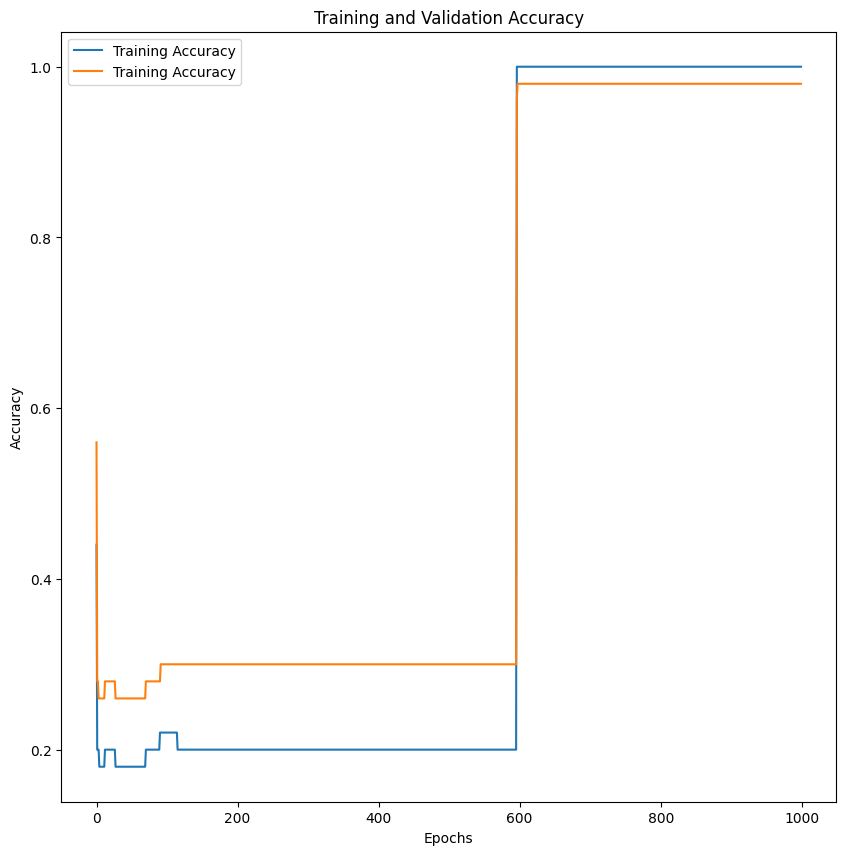

In [26]:
show_results(history)

Wnioski:
- ...
- ...

In [45]:
def calculate_metrics(test_set: pd.DataFrame) -> np.ndarray:
    results: np.ndarray = np.zeros((len(test_set),), dtype=np.float32)
    
    for i, row in enumerate(test_set.iterrows()):
        target = pd.Series(row[len(row) - 1])
        target_value = target['score']

        target.drop("target", inplace=True)
        
        predicted = magn.predict(target, 'score')
        results[i] = float(target_value == predicted)
    
    return results

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [ ]:
metrics = calculate_metrics(validation_data)

metrics

In [46]:
print(f'Accuracy: {metrics.sum() / VALIDATION_SIZE}')

Accuracy: 0.98


In [47]:
metrics = calculate_metrics(test_data)

metrics

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [48]:
print(f'Accuracy: {metrics.sum() / TEST_SIZE}')

Accuracy: 1.0


In [49]:
train_data = labeled_data[: TEST_SIZE + VALIDATION_SIZE]
test_data = labeled_data[TEST_SIZE + VALIDATION_SIZE:]

In [ ]:
history = magn.fit(train_data, num_epochs=EPOCHS, learning_rate=LEARNING_RATE, validation_data=validation_data)

In [ ]:
show_results(history)

In [ ]:
metrics = calculate_metrics(test_data)

metrics

In [ ]:
print(f'Accuracy: {metrics.sum() / TEST_SIZE}')

### Wnioski:
- Czas liczenia jest bardzo duży, głównie z uwagi, że dane MAGN nie są blisko siebie w pamięci (są w postaci grafu) i nie da się go sprawnie wczytać do pamięci typu L1, L2 na procesorze.
- Całość działa sprawnie pod względem porównania metryk uczenia (są bliskie 100%).
- Wielokrotne wykorzystanie klas w Python -ie jest bardzo wolne i funkcyjne podejście powinno górować, ponieważ obiekty w python -ie to tak naprawdę wrapery dookoła dict.

### Co się nauczyliśmy:
- Jak działają poszczególne struktury danych. Jakie mają operacje wstawianie / usuwania itd.:
    - ASA
    - MAGN
    - B-Drzewa
- Jak przeprowadzić uczenie / predykcję dla MAGN.
- Jak zrobić transformatę arbitralnej bazy danych do MAGN.
- Jak pracować z bazą danych typu SQLite przy pomocy Pythona:
    - Jak utworzyć klucze główne, obce dla tabel, już wcześniej stworzonych.
    - Jak dostać jakie kolumny, tabele ma baza danych (meta dane o schemacie bazy).
- Wizualizacje przy pomocy Graphviza MAGN (Jak działa Graphviz i jak go użyć do wizualizacji).
- Jak w PyCharm wygenerować diagram ERD dla bazy danych.
- Jak działa i jak zaimplementować sortowanie topologiczne.
- Jak poprawnie stworzyć package w python- ie.

### Źródła:

Wykorzystane przez nas materiały / artykuły niezbędne do stworzenia tego projektu.
- Construction and Training of Multi-Associative Graph Networks, Adrian Horzyk, Daniel Bulanda, and Janusz A. Starzyk
- Associative Data Structures and Associative Neural Graphs, Adrian Horzyk [LINK](https://home.agh.edu.pl/~horzyk/lectures/ci/CI-AssociativeNeuralGraphs.pdf)
- ASA-graphs for efficient data representation and processing [LINK](https://sciendo.com/article/10.34768/amcs-2020-0053)
- How to Use Associative Knowledge Graphs to Build Efficient Knowledge Models [LINK](https://grapeup.com/blog/associative-knowledge-graphs)
- Building ASA Graphs [LINK](https://youtube.com/watch?v=K1a2Bk8NrYQ&si=n5OPz9_Em5TVgX_2)